In [1]:
import os
import sys
import json
import importlib
from pathlib import Path
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../external/PCDMs/src'))

import pcdms
from constants import MODELS_SAVE_PATH, BASE_DIR

import torch
from controlnet_aux import OpenposeDetector

2025-06-05 10:31:56.878381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 10:31:57.124995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 10:31:57.228665: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 10:31:57.460172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 10:32:01.557734: W tensorflow/compiler/tf2

In [2]:
# importlib.reload(pcdms.pcdm_utils)
# importlib.reload(pcdms.pcdm_model)

from pcdms.pcdm_utils import *
from pcdms.pcdm_model import *

In [3]:
dtype = torch.float16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
pipe, unet, pose_proj_model, image_proj_model = load_pipeline_components(device, dtype)

Some weights of Stage2_InapintUNet2DConditionModel were not initialized from the model checkpoint at stabilityai/stable-diffusion-2-1-base and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 9, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/aliaagheis/projects/Ad-Image-Generation/src/pcdms/pcdm_model.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed duri

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/aliaagheis/miniconda3/envs/fast_env/lib/python3.12/site-packages/diffusers/loaders/lora_pipeline.py:3811: FutureWarning: `LoraLoaderMixin` is deprecated and will be removed in version 1.0.0. LoraLoaderMixin is deprecated and this will be removed in a future version. Please use `StableDiffusionLoraLoaderMixin`, instead.
  deprecate("LoraLoaderMixin", "1.0.0", deprecation_message)


In [5]:
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)
image_encoder = Dinov2Model.from_pretrained("facebook/dinov2-giant").type(dtype).to(device)
image_encoder_g = CLIPVisionModelWithProjection.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K", torch_dtype=dtype).to(device)

/home/aliaagheis/miniconda3/envs/fast_env/lib/python3.12/site-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.t

In [6]:
image_encoder_g.requires_grad_(False)
image_encoder.requires_grad_(False)

print("all loaded")

all loaded


In [7]:
image_size = (1024, 1024)
ASSETS_DIR = BASE_DIR / "assets"
src_img = Image.open(ASSETS_DIR / "mo_salah.jpg").resize(image_size, Image.BICUBIC)
# src_img.save("mo_salah_resized.jpg")

In [8]:
# image_size = (512, 512)
tar_pose_img = Image.open(ASSETS_DIR / "mo_salah_straight.jpg").resize(image_size, Image.BICUBIC)
# src_img.save("mo_salah_straight_resized.jpg")

In [9]:
src_img = Image.open(ASSETS_DIR / "mo_salah.jpg").resize(image_size, Image.BICUBIC).convert("RGBA")
tar_img = Image.open(ASSETS_DIR / "mo_salah_straight.jpg").resize(image_size, Image.BICUBIC).convert("RGBA")
tar_pose = Image.open(ASSETS_DIR / "mo_salah_pose_2_.jpg").resize(image_size, Image.BICUBIC).convert("RGBA")
# tar_pose = inference_pose(tar_img, openpose)
# tar_pose.save(str(ASSETS_DIR / "mo_salah_pose_2_.jpg"))

In [10]:
# overlay = Image.blend(src_img, tar_img, alpha=0.5)
# overlay

In [11]:
??inference_one_image

Signature:
inference_one_image(
    pipe,
    pose_proj_model,
    image_proj_model,
    image_encoder,
    openpose,
    s_img_path='./imgs/img1.png',
    target_pose_path='./imgs/pose1.png',
    image_size=(512, 512),
    num_inference_steps=50,
    guidance_scale=2.0,
    generator=<torch._C.Generator object at 0x7f6c6b0a2af0>,
    dtype=torch.float32,
)
Docstring: <no docstring>
Source:   
def inference_one_image(pipe,
                        pose_proj_model,
                        image_proj_model,
                        image_encoder,
                        openpose,
                        s_img_path = './imgs/img1.png', target_pose_path = './imgs/pose1.png', 
                        image_size = (512, 512),
                        num_inference_steps = 50,
                        guidance_scale = 2.0,
                        generator = generator, 
                        dtype = torch.float32):
    # ======================== Preprocessing ===================================

In [12]:
# %debug
s_img_path = ASSETS_DIR / "mo_salah_resized.jpg"
t_img_path = ASSETS_DIR / "mo_salah_straight_resized.jpg"
target_pose_img = ASSETS_DIR / "mo_salah_pose_2_resized.jpg"
image_size = (512, 512)

generator = torch.Generator(device=device).manual_seed(42)

output = inference_one_image(pipe, pose_proj_model, image_proj_model, image_encoder, openpose,
                             s_img_path, target_pose_img,
                             guidance_scale=2.0,
                             num_inference_steps=50,
                             image_size=image_size, dtype=dtype,
                             generator=generator).images[-1]

simg_mask_latents torch.Size([1, 4, 64, 128])
mask torch.Size([1, 1, 64, 128])
cond_pose torch.Size([1, 320, 64, 128])
prompt_embeds torch.Size([1, 257, 1024])
negative_prompt_embeds torch.Size([1, 257, 1024])


  0%|          | 0/50 [00:00<?, ?it/s]

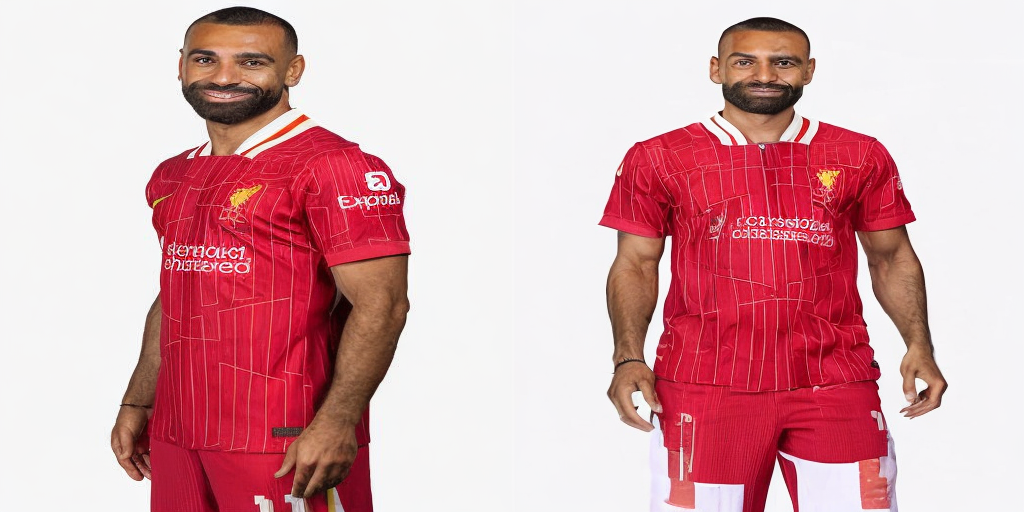

In [13]:
output

## Experiment: Tiling

In [22]:
def crop_to_512(img):
    # Get current dimensions
    width, height = img.size
    
    # Calculate the crop dimensions
    # We'll crop from the top to make it square
    new_size = min(width, height)
    left = (width - new_size) / 2
    top = 0  # Crop from top
    right = (width + new_size) / 2
    bottom = new_size
    
    # Crop the image
    img_cropped = img.crop((left, top, right, bottom))
    
    # Resize to exactly 512x512 if needed
    if new_size != 512:
        img_cropped = img_cropped.resize((512, 512), Image.LANCZOS)
    
    return img_cropped

In [37]:
src_img = crop_to_512(Image.open(ASSETS_DIR / "mo_salah.jpg"))#.resize(image_size, Image.BICUBIC).convert("RGBA")
tar_img = crop_to_512(Image.open(ASSETS_DIR / "mo_salah_hq.jpg"))#.resize(image_size, Image.BICUBIC).convert("RGBA")
tar_pose = inference_pose(tar_img, openpose)

src_img.save(ASSETS_DIR / "mo_salah_cropped.jpg")
tar_img.save(ASSETS_DIR / "mo_salah_hq_cropped.jpg")
tar_pose.save(ASSETS_DIR/"mo_salah_pose_cropped.jpg")

In [40]:
image_size = (512, 512)
# src_img = Image.open(ASSETS_DIR / "mo_salah_cropped.jpg").resize(image_size, Image.BICUBIC).convert("RGBA")
src_img = Image.open(ASSETS_DIR / "mo_salah.jpg").resize(image_size, Image.BICUBIC).convert("RGBA")
tar_img = Image.open(ASSETS_DIR / "mo_salah_hq_cropped.jpg").resize(image_size, Image.BICUBIC).convert("RGBA")
tar_pose = Image.open(ASSETS_DIR / "mo_salah_pose_cropped.jpg").resize(image_size, Image.BICUBIC).convert("RGBA")
# tar_pose = inference_pose(tar_img, openpose)
# tar_pose.save(str(ASSETS_DIR / "mo_salah_pose_2_.jpg"))

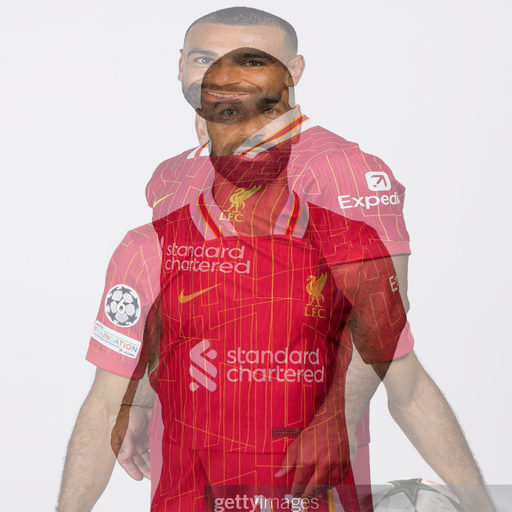

In [41]:
Image.blend(src_img, tar_img, alpha=0.5)

In [49]:
def inference_pose(img, openpose):
    pose = openpose(img, detect_resolution=img.size[1],  include_hand=True, include_face=True).resize(img.size, Image.BICUBIC)
    return pose

inference_pose(Image.open(ASSETS_DIR / "mo_salah_top_1.png"), openpose).save(ASSETS_DIR / "mo_salah_top_pose_1.png")
inference_pose(Image.open(ASSETS_DIR / "mo_salah_top_2.png"), openpose).save(ASSETS_DIR / "mo_salah_top_pose_2.png")

In [53]:
# %debug
s_img_path = ASSETS_DIR / "mo_salah_top_1.png"
target_pose_img = ASSETS_DIR / "mo_salah_pose_2_resized.jpg"
image_size = (512, 512)

generator = torch.Generator(device=device).manual_seed(42)

output = inference_one_image(pipe, pose_proj_model, image_proj_model, image_encoder, openpose,
                             s_img_path, target_pose_img,
                             guidance_scale=2.0,
                             num_inference_steps=50,
                             image_size=image_size, dtype=dtype,
                             generator=generator).images[-1]

simg_mask_latents torch.Size([1, 4, 64, 128])
mask torch.Size([1, 1, 64, 128])
cond_pose torch.Size([1, 320, 64, 128])
prompt_embeds torch.Size([1, 257, 1024])
negative_prompt_embeds torch.Size([1, 257, 1024])


  0%|          | 0/50 [00:00<?, ?it/s]

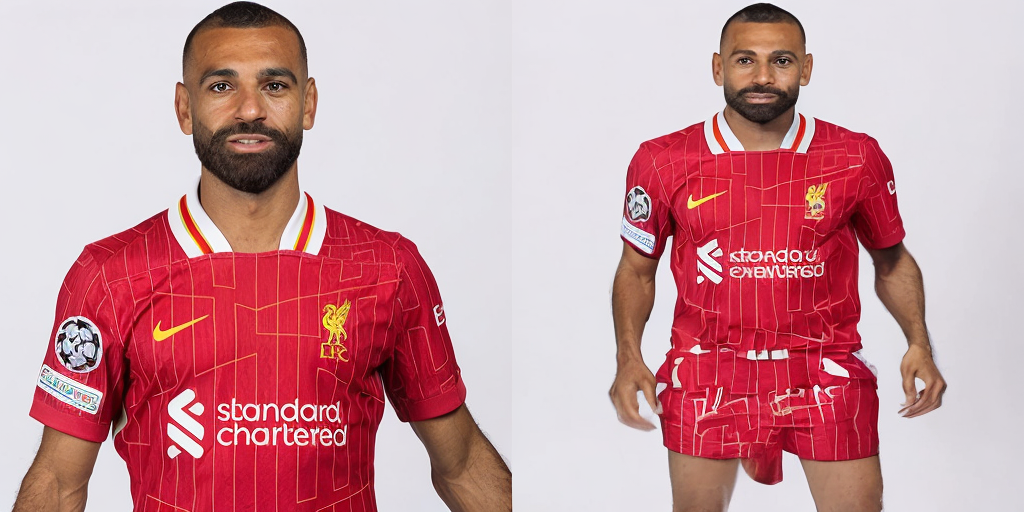

In [54]:
output

In [ ]:
s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
t_img = Image.open(t_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)
# 2. get inpainting input
simg_mask_latents = get_inpainting_inputs(pipe, s_img, dtype) # batch_size x 4 x latent_h x latent_w
mask = get_mask(simg_mask_latents.shape[2:], dtype)  # 1 x 1 x latent_h x latent_w
# 3. get conditional pose
cond_pose = get_inpainting_cond(pose_proj_model, openpose, s_img, t_pose, dtype=dtype)
# 4. get image embeddings
image_prompt_embeds, uncond_image_prompt_embeds = get_image_embeddings(image_encoder, image_encoder_g, image_proj_model, s_img, t_img, dtype=dtype)

In [ ]:
output = pipe(
            simg_mask_latents= simg_mask_latents,
            mask = mask,
            cond_pose = cond_pose,
            prompt_embeds=image_prompt_embeds,
            negative_prompt_embeds=uncond_image_prompt_embeds, # ??
            height=image_size[1],
            width=image_size[0]*2, # for inpainting mask
            num_images_per_prompt=1,
            # guidance_scale=guidance_scale,
            generator=generator,
            num_inference_steps=50,
        )

RuntimeError: The size of tensor a (258) must match the size of tensor b (77) at non-singleton dimension 1